In [1]:
import re
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
MODEL_FILE = 'out/models/j-e29-l0.63379.hdf5'
MSGS_DIR = 'out/msgs'
IMG_SHAPE = (16, 515)

In [3]:
test_files = pd.read_csv('sample_submission.csv').File.values
model = keras.models.load_model(MODEL_FILE)

In [4]:
def process_batch(files, msgs, model, res_df=None):
    
    msgs = np.array(msgs, dtype=np.float32).reshape((-1,) + IMG_SHAPE)
    y_p = model.predict(msgs, verbose=True, batch_size=8)
    batch_df = pd.DataFrame({'File': files, 'Class': y_p.T[0]})

    if res_df is None:
        return batch_df
    else:
        return res_df.append(batch_df)

In [5]:
BATCH_SIZE = 50000
batch_files = []
batch_msgs = []
res_df = None

for f in tqdm(test_files):
    
    fid = re.findall(r'(.+)\.mat$', f)[0]
    batch_files.append(f)
    
    # read wave
    msgs_f = MSGS_DIR + '/' + fid + '.npy'
    msg = np.load(msgs_f)
    # move channel axis
#     msg = np.swapaxes(msg, 0, 1)
#     msg = np.swapaxes(msg, 1, 2)
    batch_msgs.append(msg)
    
    if len(batch_files) == BATCH_SIZE:
        break
        res_df = process_batch(batch_files, batch_msgs, model, res_df)
        batch_files = []
        batch_msgs = []

if len(batch_files):
    res_df = process_batch(batch_files, batch_msgs, model, res_df)

100%|██████████| 6126/6126 [00:01<00:00, 5786.89it/s]


Exception: Error when checking : expected dense_input_1 to have 2 dimensions, but got array with shape (8168, 16, 16, 48)

In [45]:
res = {
    'File': [],
    'Class': []
}

for i in tqdm(range(len(batch_msgs))):
    f = batch_files[i]
    mm = batch_msgs[i]
#     patient = {'1':[1.,0.,0],'2':[0.,1.,0.],'3':[0.,0.,1.]}[f[0]]
    mm = mm.reshape([16, 16*64])
    yy = model.predict(mm)
    res['File'].append(f)
    res['Class'].append(np.median(yy.T[0]))

100%|██████████| 6126/6126 [00:04<00:00, 1471.93it/s]


In [46]:
res_df = pd.DataFrame(res)

In [47]:
res_df

,Class,File
0,0.200035,1_1.mat
1,0.209073,1_2.mat
2,0.221352,1_3.mat
3,0.243486,1_4.mat
4,0.211806,1_5.mat
5,0.270618,1_6.mat
6,0.208617,1_7.mat
7,0.258312,1_8.mat
8,0.219438,1_9.mat
9,0.223103,1_10.mat


In [48]:
res_df.to_csv('subm-j.csv', index=False, columns=['File', 'Class'], float_format='%.8f')

(array([  1.05000000e+03,   1.31800000e+03,   1.31800000e+03,
          1.68900000e+03,   2.98000000e+02,   1.37000000e+02,
          1.14000000e+02,   1.80000000e+02,   2.10000000e+01,
          1.00000000e+00]),
 array([ 0.17969453,  0.21842886,  0.25716319,  0.29589752,  0.33463185,
         0.37336618,  0.41210051,  0.45083483,  0.48956916,  0.52830349,
         0.56703782]),
 <a list of 10 Patch objects>)

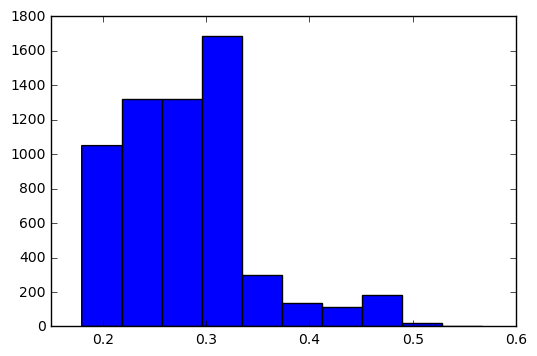

In [50]:
plt.hist(res_df.Class.values, bins=10)